In [4]:
import importlib
import sys

sys.path.append("..")  # Ensure the parent directory is in the path

from dataclasses import dataclass
from data_preprocessing.dataset_dataloader import create_data_loader
from torch import nn
from transformers import AutoTokenizer

# --- Local Application/Module Imports ---
import data_loader.data_loader
import data_preprocessing.data_preprocessing
import data_preprocessing.llm_augmentation
import models.models
import visualizations.visualizations
import utils.utils

importlib.reload(data_loader.data_loader)
from data_loader.data_loader import *

importlib.reload(data_preprocessing.data_preprocessing)

importlib.reload(data_preprocessing.llm_augmentation)
from data_preprocessing.llm_augmentation import *

importlib.reload(models.models)
from models.models import *

importlib.reload(visualizations.visualizations)
from visualizations.visualizations import *

importlib.reload(utils.utils)
from utils.utils import *

# --- Notebook Configuration ---
%matplotlib inline
%config InlineBackend.figure_format='retina'

# --- Global Settings ---
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tnorlha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/tnorlha/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tnorlha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
train_df, val_df, test_df = load_and_split_data()

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 81677
Validation size: 10210
Test size: 10210


In [6]:
device = get_device()
print(f"Using device: {device}")

Using device: mps


# Load Roberta large 4 epoch, batch size 16

## Baseline finetuned-model

In [7]:
train_df, val_df, test_df = load_and_split_data()

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 81677
Validation size: 10210
Test size: 10210


In [8]:
@dataclass
class Config:
    batch_size: int
    model: str
    seed: int
    lr: float
    dropout: float
    attention_dropout: float
    device: str
    num_classes: int
    max_len: int



config = Config(
    batch_size = 16,
    model="FacebookAI/roberta-large",
    seed=RANDOM_SEED,
    lr=3e-5,
    dropout=0.1,
    attention_dropout=0.1,
    device=device,
    num_classes=3,
    max_len=64,
)

roberta_tokenizer = AutoTokenizer.from_pretrained(config.model)
roberta_model = load_blank_model(config)

# Load saved model state dict
checkpoint_path = "roberta-large.bin"
state_dict = torch.load(checkpoint_path, map_location=device)
roberta_model.load_state_dict(state_dict)

roberta_model.to(device)
roberta_model.eval()


loss_fn = nn.CrossEntropyLoss().to(device)
test_data_loader = create_data_loader(test_df, roberta_tokenizer, config.max_len, config.batch_size)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
test_acc, _ = eval_model(
    roberta_model,
    test_data_loader,
    loss_fn,
    device
)

test_acc.item()

0.7953173814832107

In [10]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    roberta_model,
    test_data_loader,
    device
)

In [11]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, labels=[0, 1, 2], target_names=class_names))

              precision    recall  f1-score   support

    negative       0.77      0.74      0.76      2191
     neutral       0.83      0.83      0.83      4915
    positive       0.79      0.81      0.80      3104

    accuracy                           0.81     10210
   macro avg       0.80      0.79      0.80     10210
weighted avg       0.81      0.81      0.81     10210



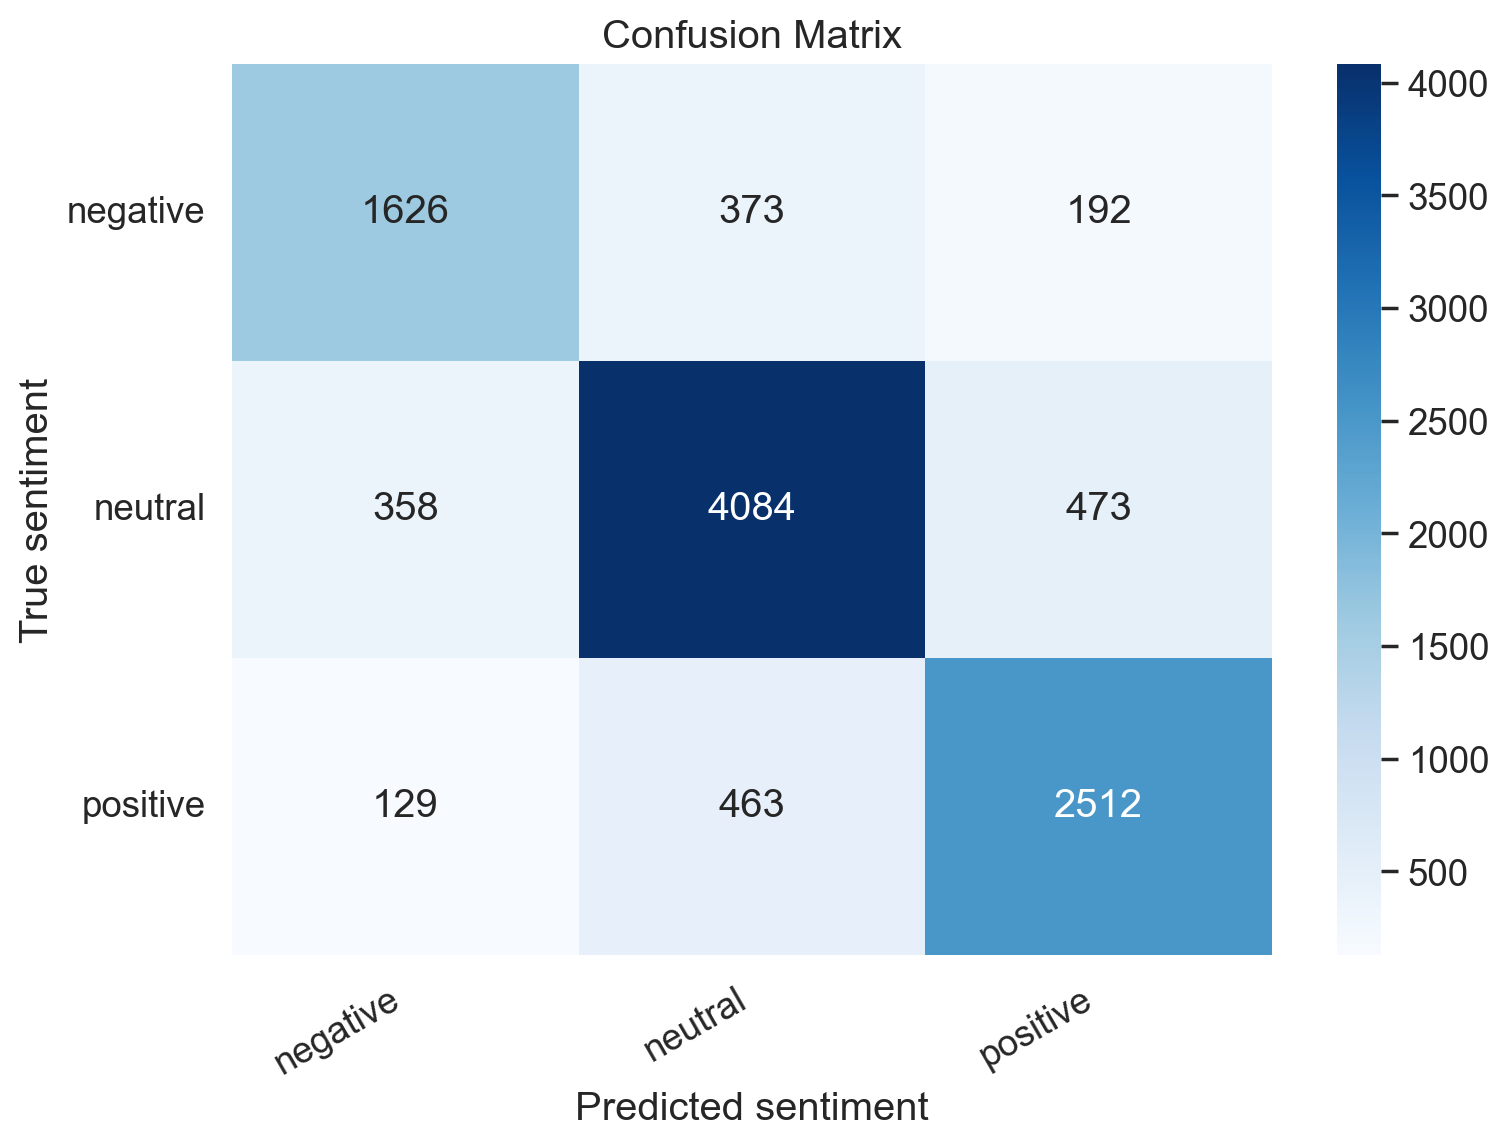

In [12]:
plot_confusion_matrix(y_test, y_pred, class_names)

### Inspect Misclassified Examples

In [18]:
neg_label = 0  # assuming 'negative' is label 0
pos_label = 2  # assuming 'positive' is label 2

# False negatives for positive = positives predicted as negative
false_negatives_pos = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true == pos_label and pred == neg_label]

# False positives for positive = negatives predicted as positive
false_positives_pos = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true == neg_label and pred == pos_label]

print("False negatives for positive (missed positives):", len(false_negatives_pos))
print("False positives for positive (wrongly predicted positives):", len(false_positives_pos))
print()

for i in false_negatives_pos[:10]:
    print(f"Text: {test_df.iloc[i]['text']}")
    print(f"True label: {class_names[y_test[i]]}, Predicted: {class_names[y_pred[i]]}")
    print("-"*80)

False negatives for positive (missed positives): 129
False positives for positive (wrongly predicted positives): 192

Text: Alas, I should've had more faith in my beloved Trader's.
True label: positive, Predicted: negative
--------------------------------------------------------------------------------
Text: I got nauseous and before I could even let someone know, 3-4 staff members ran over and were placing cold packs under my clothes and talking me through it.
True label: positive, Predicted: negative
--------------------------------------------------------------------------------
Text: Amazingly dopey .
True label: positive, Predicted: negative
--------------------------------------------------------------------------------
Text: Show is 90 minutes long and doesn't feel like it at all.
True label: positive, Predicted: negative
--------------------------------------------------------------------------------
Text: Try: The Vito with hot peppers

Avoid: The mayo on the Italian Nightclub

In [19]:
fn_pos_df = test_df.iloc[false_negatives_pos].copy()
fp_pos_df = test_df.iloc[false_positives_pos].copy()

### Probability confidence analysis

Look at the predicted probabilities to find:

Low confidence correct predictions (maybe the model is unsure even when right).
High confidence wrong predictions (model is confident but wrong → problematic).

In [14]:
probs = np.array(y_pred_probs)
max_probs = probs.max(axis=1)
misclassified_confident = [(i, max_probs[i]) for i in misclassified_indices if max_probs[i] > 0.8]

print("Some highly confident misclassifications:")
for idx, conf in misclassified_confident[:5]:
    print(f"Text: {test_df.iloc[idx]['text']}")
    print(f"Confidence: {conf:.2f}, True: {class_names[y_test[idx]]}, Predicted: {class_names[y_pred[idx]]}")
    print("-" * 80)


Some highly confident misclassifications:
Text: Last summer I called and spoke to Tom on a Saturday trying to get a quote for a water softener.
Confidence: 0.98, True: positive, Predicted: neutral
--------------------------------------------------------------------------------
Text: Turned out the switch they Needed wasn't in stock.
Confidence: 0.97, True: neutral, Predicted: negative
--------------------------------------------------------------------------------
Text: You also can't leave without trying foods from the taco stand in the back of the store.
Confidence: 0.98, True: neutral, Predicted: positive
--------------------------------------------------------------------------------
Text: Gloriously straight from the vagina .
Confidence: 0.99, True: neutral, Predicted: positive
--------------------------------------------------------------------------------
Text: Mini chocolate chips were Walmart House Brand quality.
Confidence: 0.97, True: negative, Predicted: positive
----------